# Library Import Initiation

In [1]:
import pandas as pd
import math
import json
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy

from sklearn.preprocessing import LabelEncoder, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import joblib

In [3]:
process = {}

def show_process(add):
    global process
    if add not in process.values():
        index = len(process) + 1  # 自动递增的key，从1开始
        process[index] = add
        prdf = pd.DataFrame.from_dict(process, orient='index', columns=['Process'])
    return prdf

# Dataset Import and Primary processing

In [4]:
df = pd.read_csv("/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/CAPSTONE/Other/ad_performance.csv", index_col=0)
df = df.drop(columns=["channelcode"])

In [5]:
show_process("Data loaded")

,Process
1,Data loaded


In [6]:
cols = df.columns.to_list()
print(cols)
for a in cols:
    print(f"{a}, {len(df[a].unique())}")

['uv', 'regis', 'search', 'visitdepth', 'stay', 'ocr', 'duration', 'material', 'placement', 'payment', 'size', 'sellingpoint']
uv, 809
regis, 104
search, 290
visitdepth, 848
stay, 871
ocr, 124
duration, 30
material, 4
placement, 5
payment, 4
size, 8
sellingpoint, 6


In [7]:
print("placement unique:", df['placement'].unique())
print("placement value counts:\n", df['placement'].value_counts())
print("sellingpoint unique:", df['sellingpoint'].unique())
print("sellingpoint value counts:\n", df['sellingpoint'].value_counts())

placement unique: ['banner' 'tips' '不确定' '横幅' '暂停']
placement value counts:
 placement
横幅        348
不确定       313
banner    154
tips       73
暂停          1
Name: count, dtype: int64
sellingpoint unique: ['打折' '满减' '满赠' '秒杀' '直降' '满返']
sellingpoint value counts:
 sellingpoint
直降    345
打折    214
满减    154
满返     70
秒杀     55
满赠     51
Name: count, dtype: int64


In [8]:
# 删除placement为"暂停"的行
df = df[df['placement'] != "暂停"]
df = df[df['material'] != "sp"]

# 替换placement中的"横幅"为"sub-banner"，"不确定"为"uncertained"
df['placement'] = df['placement'].replace({"横幅": "sub-banner", "不确定": "uncertained"})

df['sellingpoint'] = df['sellingpoint'].replace({
    "直降": "Price Drop",
    "打折": "Discount",
    "满减": "Spend & Save",
    "满返": "Cash/Coupon-Back",
    "满赠": "Gift with Purchase",
    "秒杀": "Flash Sale"
    })



In [9]:
show_process("无用数据删除+中文替换")

,Process
1,Data loaded
2,无用数据删除+中文替换


In [10]:
print("placement unique:", df['placement'].unique())
print("placement value counts:\n", df['placement'].value_counts())

placement unique: ['banner' 'tips' 'uncertained' 'sub-banner']
placement value counts:
 placement
sub-banner     348
uncertained    313
banner         153
tips            73
Name: count, dtype: int64


In [11]:
print("sellingpoint unique:", df['sellingpoint'].unique())
print("sellingpoint value counts:\n", df['sellingpoint'].value_counts())

sellingpoint unique: ['Discount' 'Spend & Save' 'Gift with Purchase' 'Flash Sale' 'Price Drop'
 'Cash/Coupon-Back']
sellingpoint value counts:
 sellingpoint
Price Drop            343
Discount              214
Spend & Save          154
Cash/Coupon-Back       70
Flash Sale             55
Gift with Purchase     51
Name: count, dtype: int64


In [ ]:
# Decode 'ocr' column
df['ocr'] = df['ocr']* 100

In [14]:
show_process("\'OCR\'列还原")

,Process
1,Data loaded
2,无用数据删除+中文替换
3,'OCR'列还原


## Missing Value and Duplication Check

In [15]:
# 检查是否有空值
print("Nah Detected:")
print(df.isnull().sum())

# 检查是否有重复值
duplicate_count = df.duplicated().sum()
print(f"Duplication Detected: {duplicate_count}")

Nah Detected:
uv              0
regis           0
search          0
visitdepth      0
stay            2
ocr             0
duration        0
material        0
placement       0
payment         0
size            0
sellingpoint    0
dtype: int64
Duplication Detected: 0


In [16]:
df['stay'] = df['stay'].fillna(df['stay'].mean())

In [17]:
print("Nah Detected:")
print(df.isnull().sum())

Nah Detected:
uv              0
regis           0
search          0
visitdepth      0
stay            0
ocr             0
duration        0
material        0
placement       0
payment         0
size            0
sellingpoint    0
dtype: int64


In [18]:
show_process("空值处理")

,Process
1,Data loaded
2,无用数据删除+中文替换
3,'OCR'列还原
4,空值处理


# Variables Define

In [19]:
main_num_cols = ["uv", "search", "ocr"]
main_cat_cols = ["material", "placement", "payment", "sellingpoint"]

In [20]:
show_process("Columns defined")

,Process
1,Data loaded
2,无用数据删除+中文替换
3,'OCR'列还原
4,空值处理
5,Columns defined


# num_var Handling

In [21]:
def calculate_outlier_proportion(dataf, columns, method="IQR"):
    """
    计算 DataFrame 中每个数值变量的异常值占比（默认使用 IQR 法）
    
    参数:
        df: pandas DataFrame
        columns: 要检测的列名列表，默认自动检测数值列
        method: 暂时支持 "IQR"
    
    返回:
        pandas DataFrame，包含变量名、异常值数量、总数、占比%
    """

    outlier_info = []

    for col in columns:
        series = dataf[col].dropna()
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outliers = series[(series < lower) | (series > upper)]
        outlier_count = len(outliers)
        total_count = len(series)
        proportion = outlier_count / total_count * 100

        outlier_info.append({
            "Variable": col,
            "Outliers": outlier_count,
            "Total": total_count,
            "Proportion (%)": round(proportion, 2)
        })

    return print(pd.DataFrame(outlier_info))


def plot_outliers(num_cols, dataf):
    sns.set_theme(style="whitegrid")

    cols_per_row = 3
    num_plots = len(num_cols)
    num_rows = math.ceil(num_plots / cols_per_row)

    fig, axes = plt.subplots(
        nrows=num_rows,
        ncols=cols_per_row,
        figsize=(3.2 * cols_per_row, 4.5 * num_rows),
        dpi=300
    )
    axes = axes.flatten()

    for i, col in enumerate(num_cols):
        ax = axes[i]
        
        # 画 boxplot
        sns.boxplot(y=dataf[col], ax=ax, color="skyblue", width=0.5, fliersize=0)  # 关闭默认的异常点显示

        # 手动计算 outliers（IQR方法）
        Q1 = dataf[col].quantile(0.25)
        Q3 = dataf[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = dataf[(dataf[col] < lower_bound) | (dataf[col] > upper_bound)][col]

        # 画红点
        ax.scatter([0] * len(outliers), outliers, color='pink', s=10, label='Outlier', zorder=3)

        ax.set_title(f"{col}", fontsize=10, fontweight='bold')
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.grid(True, linestyle="--", alpha=0.5)

    for j in range(num_plots, len(axes)):
        axes[j].axis("off")

    plt.tight_layout(pad=1.0)
    plt.show()

    calculate_outlier_proportion(dataf, num_cols)

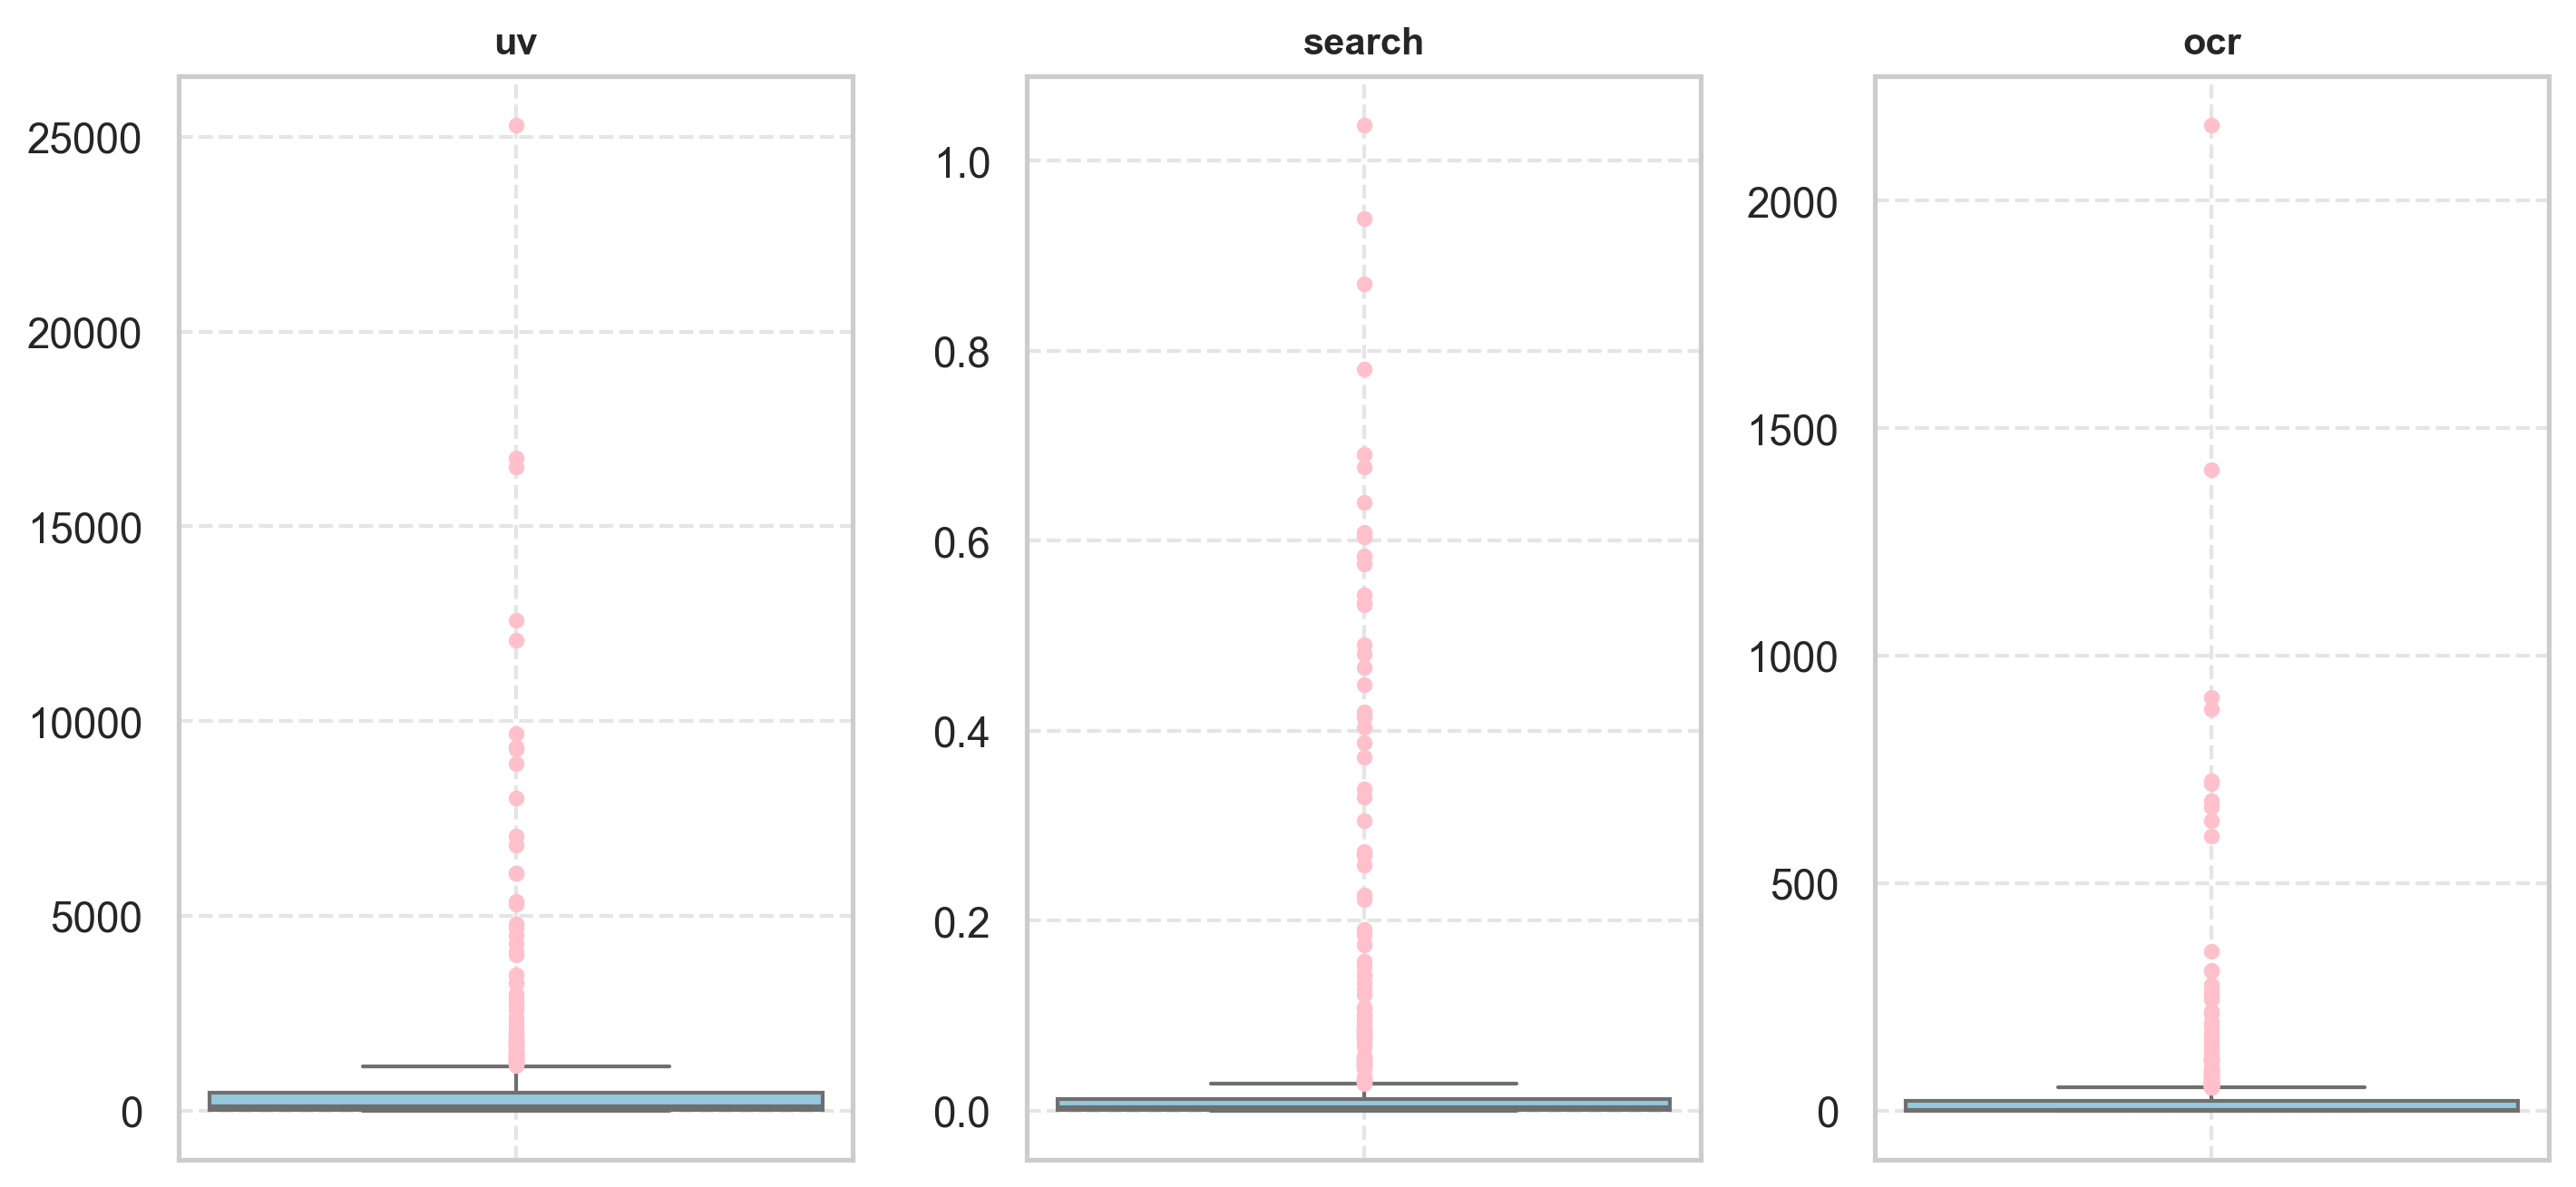

  Variable  Outliers  Total  Proportion (%)
0       uv        87    887            9.81
1   search       101    887           11.39
2      ocr       103    887           11.61


In [22]:
plot_outliers(main_num_cols, df)

## Remove Outliers

In [23]:
def remove_outliers_iqr(dataf, columns):
    """
    Remove rows containing outliers (using IQR method) for specified columns.
    """
    df_clean = dataf.copy()
    print(f"Shape before removing outliers: {df_clean.shape}")
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    print(f"Shape after removing outliers: {df_clean.shape}")
    return df_clean


In [24]:
df_no_outliers = remove_outliers_iqr(df, main_num_cols)
df_no_outliers.reset_index(drop=True, inplace=True)

Shape before removing outliers: (887, 12)
Shape after removing outliers: (625, 12)


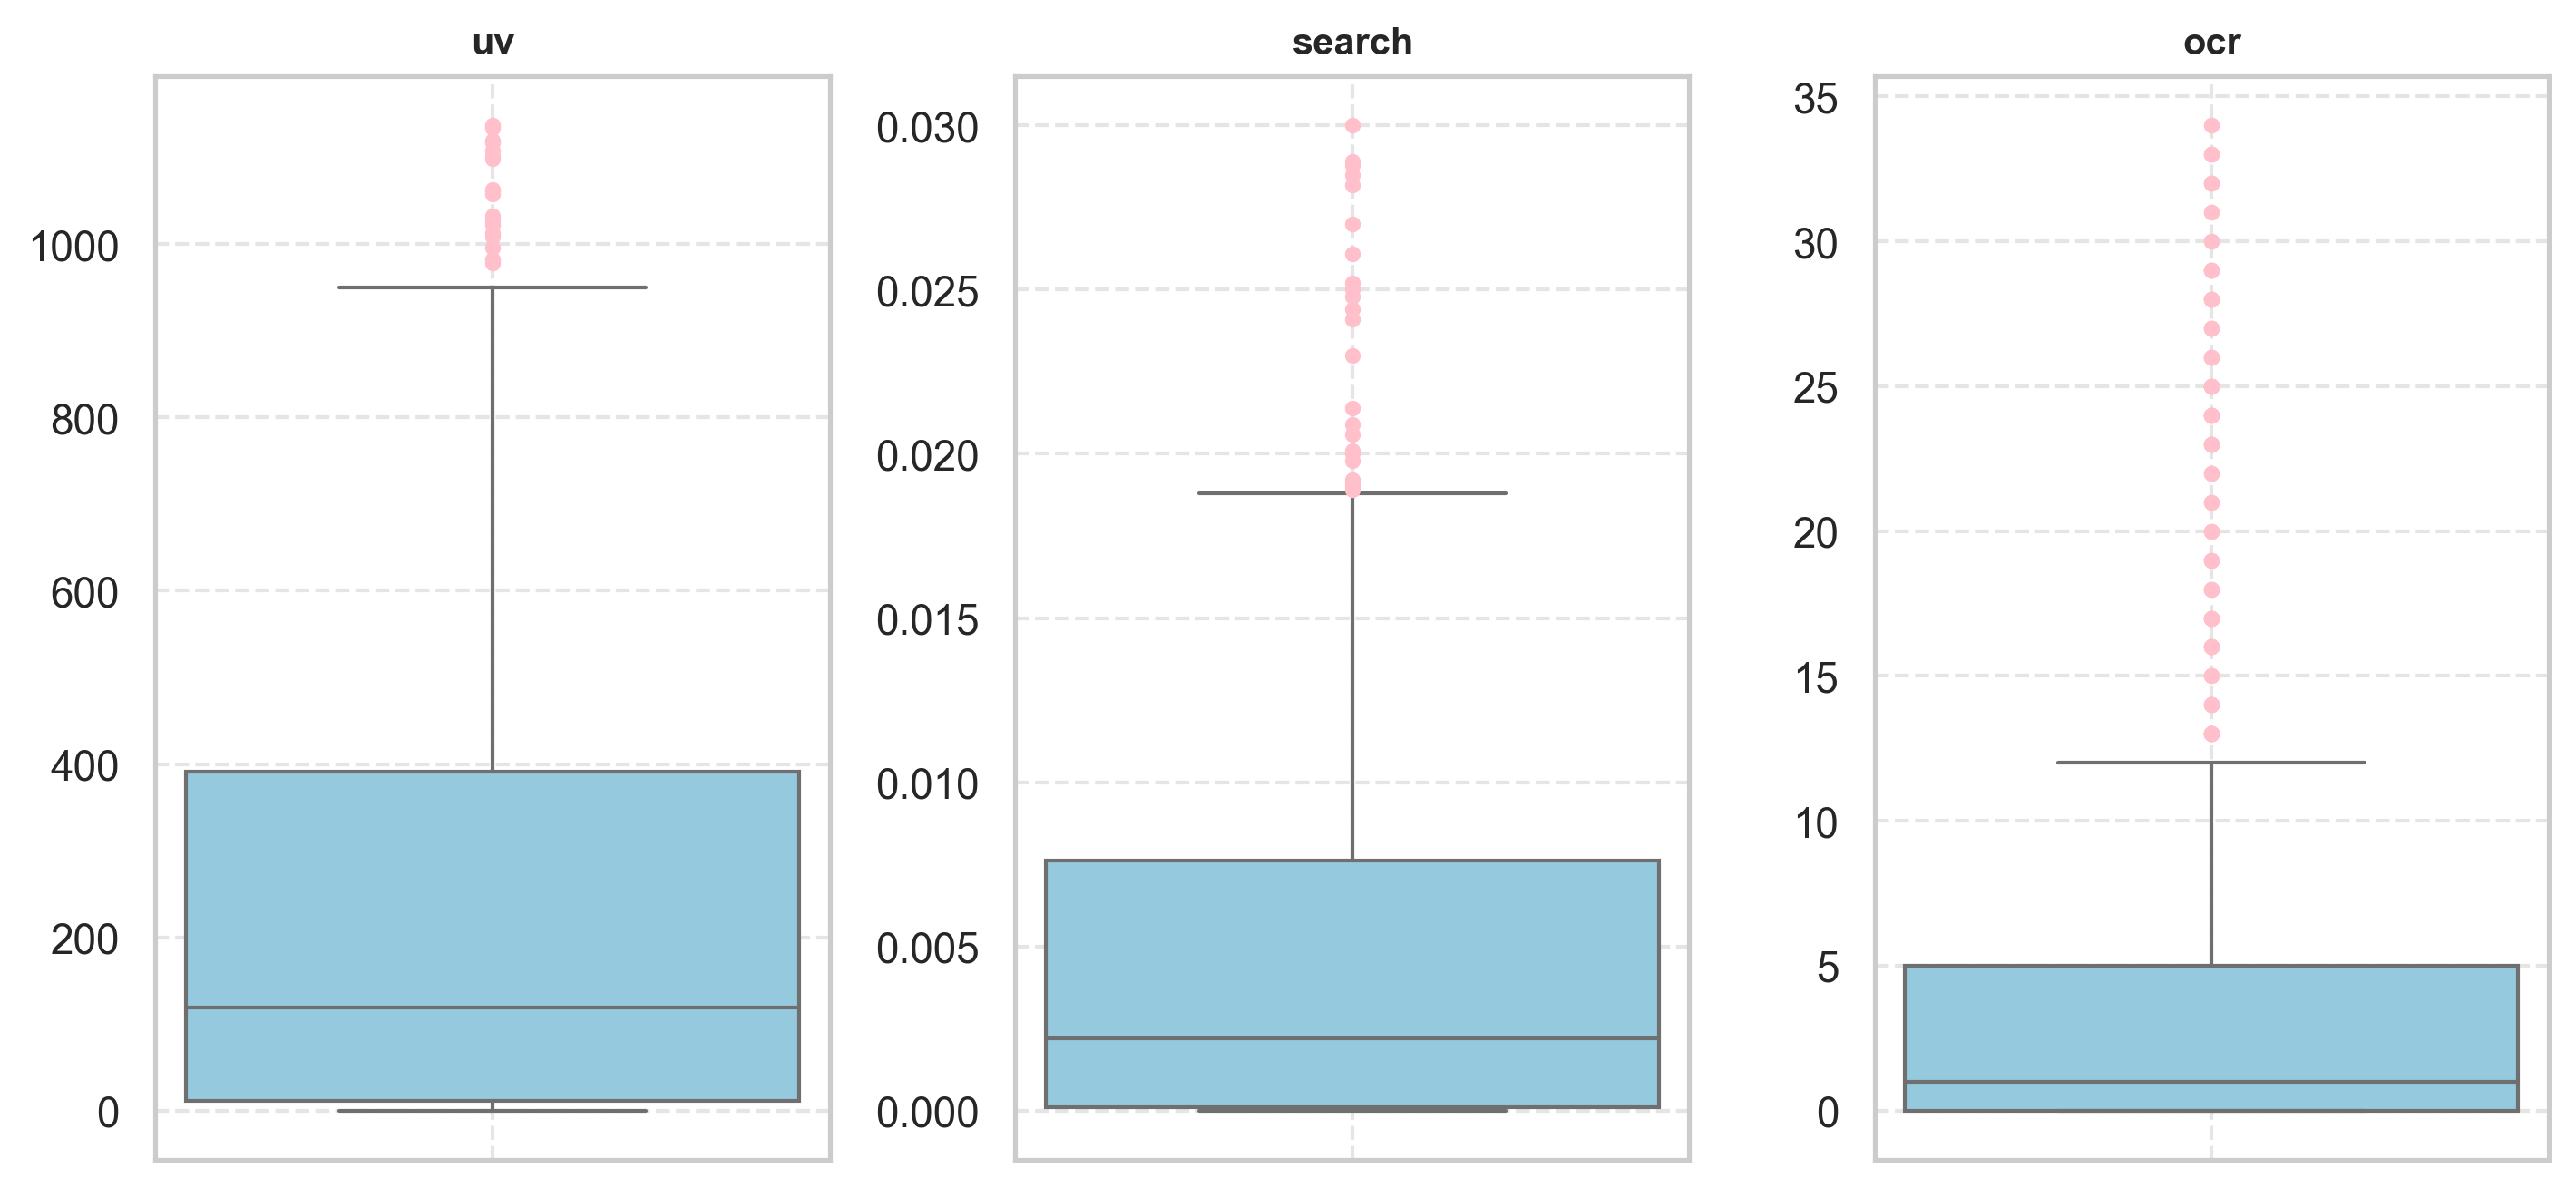

  Variable  Outliers  Total  Proportion (%)
0       uv        20    625            3.20
1   search        23    625            3.68
2      ocr       112    625           17.92


In [25]:
plot_outliers(main_num_cols,df_no_outliers)

In [ ]:
df_no_outliers.to_csv("ad_performance_no_outliers.csv", index=False)

In [57]:
print(f"{df_no_outliers['uv'].mean()}\n{df_no_outliers['search'].mean()}\nb{df_no_outliers["ocr"].mean()}")

238.26190400000002
0.00465536
b0.05112


In [59]:
show_process("Outliers removed")

,Process
1,Data loaded
2,无用数据删除+中文替换
3,'OCR'列还原
4,空值处理
5,Columns defined
6,Outliers removed


## Scaling of num_cols
Robust Scaling for MOC-MLP and Regression-MLP

In [4]:
def scale_with_robust_scaler(df, columns, scaler_save_path="scalers"):
    """
    使用 RobustScaler 对指定列进行缩放（基于中位数和 IQR），并保存每列的 scaler。
    
    参数：
        df: pandas DataFrame
        columns: 要缩放的列名列表
        scaler_save_path: 保存 scaler 的文件夹路径（默认为 "scalers"）

    返回：
        缩放后的 DataFrame
    """
    original_shape = df.shape
    df_scaled = df.copy()

    # 创建保存路径
    os.makedirs(scaler_save_path, exist_ok=True)

    for col in columns:
        scaler = RobustScaler()
        df_scaled[col] = scaler.fit_transform(df[[col]])
        
        # 保存 scaler 到指定路径，以列名命名
        scaler_path = os.path.join(scaler_save_path, f"{col}_robust_scaler.pkl")
        joblib.dump(scaler, scaler_path)

    print(f"✅ Scaling complete using RobustScaler.")
    print(f"📏 缩放列: {columns}")
    print(f"💾 所有 scaler 已保存至文件夹: '{scaler_save_path}'")

    return df_scaled

In [8]:
df_to_scale = pd.read_csv("/Users/JackRuan/文稿(un-iCloud)/VScode_ipynb/CAPSTONE/Pipelines/balanced_output_smote(2).csv", index_col=False)

In [9]:
df_robust_scaled = scale_with_robust_scaler(df_to_scale, main_num_cols, scaler_save_path="scalers")

✅ Scaling complete using RobustScaler.
📏 缩放列: ['uv', 'search', 'ocr']
💾 所有 scaler 已保存至文件夹: 'scalers'


In [63]:
df_robust_scaled= df_robust_scaled[main_num_cols + main_cat_cols]
df_robust_scaled

,uv,search,ocr,material,placement,payment,sellingpoint
0,0.015820,1.440000,3.4,jpg,banner,cpc,Spend & Save
1,-0.010950,2.160000,3.4,jpg,banner,cpc,Spend & Save
2,-0.281198,2.213333,4.6,jpg,banner,cpc,Spend & Save
3,-0.312706,1.373333,-0.2,jpg,banner,cpc,Spend & Save
4,0.760391,1.266667,4.8,jpg,banner,cpc,Spend & Save
...,...,...,...,...,...,...,...
620,1.406781,1.173333,0.2,swf,tips,cpc,Spend & Save
621,1.508884,0.160000,0.4,swf,tips,cpc,Spend & Save
622,0.587560,1.053333,1.8,swf,tips,cpc,Discount
623,0.444368,-0.160000,0.0,swf,tips,cpc,Discount


In [65]:
show_process("num_cols scaled with RobustScaler")

,Process
1,Data loaded
2,无用数据删除+中文替换
3,'OCR'列还原
4,空值处理
5,Columns defined
6,Outliers removed
7,num_cols scaled with RobustScaler


# cat_var Handle

In [66]:
print(main_cat_cols)
for a in main_cat_cols:
    print(f"{a} unique:", df_robust_scaled[a].unique())
    print(f"{a} value counts:\n", df_robust_scaled[a].value_counts())


['material', 'placement', 'payment', 'sellingpoint']
material unique: ['jpg' 'swf' 'gif']
material value counts:
 material
jpg    403
swf    219
gif      3
Name: count, dtype: int64
placement unique: ['banner' 'tips' 'uncertained' 'sub-banner']
placement value counts:
 placement
sub-banner     281
uncertained    208
banner          99
tips            37
Name: count, dtype: int64
payment unique: ['cpc' 'cpm' 'roi' 'cpd']
payment value counts:
 payment
cpc    396
roi    174
cpm     38
cpd     17
Name: count, dtype: int64
sellingpoint unique: ['Spend & Save' 'Gift with Purchase' 'Flash Sale' 'Discount' 'Price Drop'
 'Cash/Coupon-Back']
sellingpoint value counts:
 sellingpoint
Price Drop            264
Discount              143
Spend & Save          107
Cash/Coupon-Back       47
Gift with Purchase     34
Flash Sale             30
Name: count, dtype: int64


## OneHotCoding

接下来,用df_robust_scaled做MLP-regression

In [68]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [69]:
cat_encoded = encoder.fit_transform(df_robust_scaled[main_cat_cols])
cat_encoded_df = pd.DataFrame(
    cat_encoded,
    columns=encoder.get_feature_names_out(main_cat_cols),
    index=df_robust_scaled.index
)

In [70]:
cat_encoded_df

,material_gif,material_jpg,material_swf,placement_banner,placement_sub-banner,placement_tips,placement_uncertained,payment_cpc,payment_cpd,payment_cpm,payment_roi,sellingpoint_Cash/Coupon-Back,sellingpoint_Discount,sellingpoint_Flash Sale,sellingpoint_Gift with Purchase,sellingpoint_Price Drop,sellingpoint_Spend & Save
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
621,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
622,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
623,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [71]:
cat_encoded_df.columns.tolist()

['material_gif',
 'material_jpg',
 'material_swf',
 'placement_banner',
 'placement_sub-banner',
 'placement_tips',
 'placement_uncertained',
 'payment_cpc',
 'payment_cpd',
 'payment_cpm',
 'payment_roi',
 'sellingpoint_Cash/Coupon-Back',
 'sellingpoint_Discount',
 'sellingpoint_Flash Sale',
 'sellingpoint_Gift with Purchase',
 'sellingpoint_Price Drop',
 'sellingpoint_Spend & Save']

In [72]:
df_mlp_moc = pd.concat([df_robust_scaled[['uv','search']], cat_encoded_df], axis=1)

In [74]:
df_mlp_reg = pd.concat([df_robust_scaled[['uv','search','ocr']], cat_encoded_df], axis=1)
df_mlp_reg

,uv,search,ocr,material_gif,material_jpg,material_swf,placement_banner,placement_sub-banner,placement_tips,placement_uncertained,payment_cpc,payment_cpd,payment_cpm,payment_roi,sellingpoint_Cash/Coupon-Back,sellingpoint_Discount,sellingpoint_Flash Sale,sellingpoint_Gift with Purchase,sellingpoint_Price Drop,sellingpoint_Spend & Save
0,0.015820,1.440000,3.4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.010950,2.160000,3.4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.281198,2.213333,4.6,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.312706,1.373333,-0.2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.760391,1.266667,4.8,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,1.406781,1.173333,0.2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
621,1.508884,0.160000,0.4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
622,0.587560,1.053333,1.8,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
623,0.444368,-0.160000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [75]:
df_mlp_moc

,uv,search,material_gif,material_jpg,material_swf,placement_banner,placement_sub-banner,placement_tips,placement_uncertained,payment_cpc,payment_cpd,payment_cpm,payment_roi,sellingpoint_Cash/Coupon-Back,sellingpoint_Discount,sellingpoint_Flash Sale,sellingpoint_Gift with Purchase,sellingpoint_Price Drop,sellingpoint_Spend & Save
0,0.015820,1.440000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.010950,2.160000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.281198,2.213333,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.312706,1.373333,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.760391,1.266667,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,1.406781,1.173333,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
621,1.508884,0.160000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
622,0.587560,1.053333,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
623,0.444368,-0.160000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
